# **Assignment 9** 

## Build the following network:

1. That takes a CIFAR10 image (32x32x3)
2. Add 3 Convolutions to arrive at AxAx48 dimensions (e.g. 32x32x3 | 3x3x3x16 >> 3x3x16x32 >> 3x3x32x48)
3. Apply GAP and get 1x1x48, call this X
4. Create a block called ULTIMUS that:
  - Creates 3 FC layers called K, Q and V such that:
    - X\*K = 48*48x8 > 8
    - X\*Q = 48*48x8 > 8 
    - X\*V = 48*48x8 > 8 
  - then create AM = SoftMax(QTK)/(8^0.5) = 8*8 = 8
  - then Z = V\*AM = 8*8 > 8
  - then another FC layer called Out that:
    - Z\*Out = 8*8x48 > 48
5. Repeat this Ultimus block 4 times
6. Then add final FC layer that converts 48 to 10 and sends it to the loss function.
7. Model would look like this C>C>C>U>U>U>U>FFC>Loss
8. Train the model for 24 epochs using the OCP that I wrote in class. Use ADAM as an optimizer. 
9. Submit the link and answer the questions on the assignment page:
  - Share the link to the main repo (must have Assignment 7/8/9 model7/8/9.py files (or similarly named))
  - Share the code of model9.py
  - Copy and paste the Training Log
  - Copy and paste the training and validation loss chart

In [18]:
!pip install opencv-python==4.5.5.64

In [19]:
pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/cu111/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.htmlNote: you may need to restart the kernel to use updated packages.



In [20]:
!rm -rf ./*
!git clone https://github.com/jaimr/E8MainS9
!mv E8MainS9/* ./
!rm -rf E8MainS9    
!pip install -r requirements.txt

In [21]:
import copy
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import torch.nn as nn
from utils.dataloader import Cifar10DataLoader
from models.model9 import TransformerModel
from utils.transforms import CustomResnetTransforms, DefaultTransforms
from utils.trainer import Trainer
from utils.tester import Tester
from utils.summary import print_summary
from utils.utils import show_misclassified_images, show_training_images, denormalize, show_grad_cam, show_losses_and_accuracies, get_module_by_name, get_device, show_lr_history
from main import train_model, get_lr, run # remove this
from models.model9 import UltimusNet
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [22]:
is_cuda_available, device = get_device()

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

import torch
import torch.utils.data as data

# Set the number of worker processes equal to the number of CPU cores
num_workers = torch.multiprocessing.cpu_count()
print(num_workers)

cpu
12


In [24]:
ultimusNet = UltimusNet().to(device)

In [25]:
is_cuda_available, device = get_device()
print_summary(UltimusNet(), device, input_size=(3, 32, 32))

Layer (type (var_name))                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
UltimusNet (UltimusNet)                  --                        [20, 3, 32, 32]           [20, 10]                  --                        --                        True
├─Conv2d (conv1)                         [3, 3]                    [20, 3, 32, 32]           [20, 16, 32, 32]          448                       9,175,040                 True
├─Conv2d (conv2)                         [3, 3]                    [20, 16, 32, 32]          [20, 32, 32, 32]          4,640                     95,027,200                True
├─Conv2d (conv3)                         [3, 3]                    [20, 32, 32, 32]          [20, 48, 32, 32]          13,872                    284,098,560               True
├─AdaptiveAvgPool2d (avgpool)            --                        [20, 48, 32, 32]          [20, 48, 1, 1]        

In [26]:
cifar10 = Cifar10DataLoader(CustomResnetTransforms, 512, is_cuda_available)
train_loader = cifar10.get_loader(train=True)
test_loader = cifar10.get_loader(train=False)

Files already downloaded and verified
Files already downloaded and verified


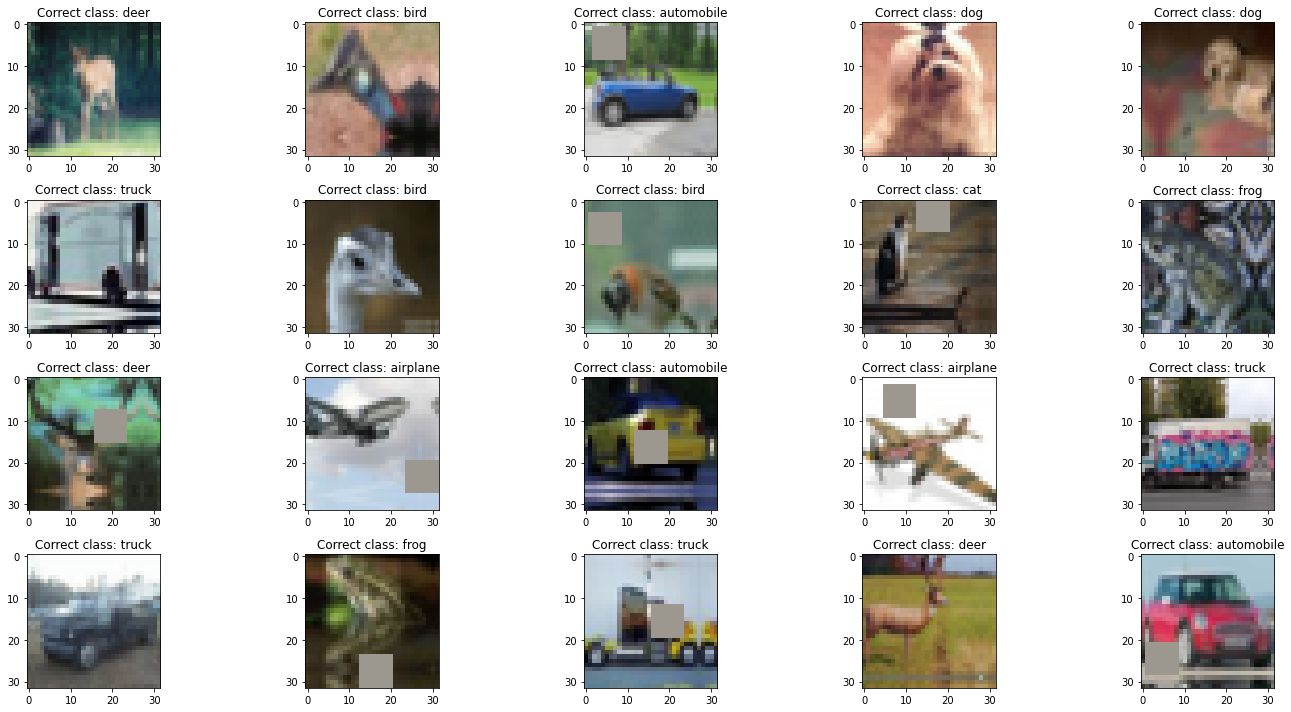

In [27]:
show_training_images(train_loader, 20, cifar10.classes)

Files already downloaded and verified


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [03:43<00:00,  1.12s/it]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.50E-06


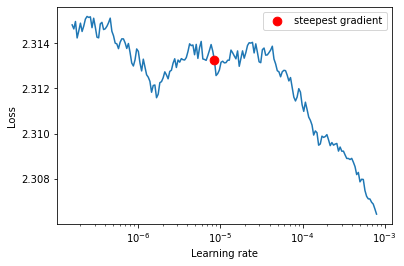

Min Loss = 2.305755832552012, Max LR = 0.001


In [28]:
model = TransformerModel()

cifar10_exp = Cifar10DataLoader(DefaultTransforms, 512, is_cuda_available, shuffle=False)
train_loader_exp = cifar10_exp.get_loader(train=True)

optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

min_loss, max_lr = get_lr(
        model=model,
        train_loader=train_loader_exp,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        end_lr=0.001,
        num_iter=200,
    )

In [29]:
max_lr = 0.001

EPOCHS = 24
lr_min = max_lr / 25
step_size = (EPOCHS - 5) // 2

'''
scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5 / EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=1000,
        anneal_strategy="linear",
    )
'''

scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5 / EPOCHS,
        div_factor=max_lr/lr_min,
        three_phase=False,
        final_div_factor=lr_min/max_lr,
        anneal_strategy="linear",
    )

trainer = Trainer(model, train_loader, optimizer, criterion, device)
tester = Tester(model, test_loader, criterion, device)

model, history = train_model(trainer, tester, NUM_EPOCHS=EPOCHS, scheduler=scheduler, save_best=False)

EPOCH = 1 | LR = 0.00023239263803680982 | Loss = 2.30 | Batch = 97 | Accuracy = 9.93: 100%|█| 98/98 [01:50<00:00,  1.13


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 2 | LR = 0.00042478527607361965 | Loss = 2.30 | Batch = 97 | Accuracy = 9.88: 100%|█| 98/98 [01:38<00:00,  1.01


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 3 | LR = 0.0006171779141104294 | Loss = 2.30 | Batch = 97 | Accuracy = 10.00: 100%|█| 98/98 [01:37<00:00,  1.01


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 4 | LR = 0.0008095705521472393 | Loss = 2.31 | Batch = 97 | Accuracy = 9.92: 100%|█| 98/98 [01:41<00:00,  1.04s


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 5 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.73: 100%|█████████████| 98/98 [01:40<00:00,  1.03s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 6 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.93: 100%|█████████████| 98/98 [01:35<00:00,  1.02it/s]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 7 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.93: 100%|█████████████| 98/98 [01:40<00:00,  1.03s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 8 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 10.00: 100%|████████████| 98/98 [01:37<00:00,  1.00it/s]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 9 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.74: 100%|█████████████| 98/98 [01:47<00:00,  1.10s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 10 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.80: 100%|████████████| 98/98 [01:44<00:00,  1.07s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 11 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.92: 100%|████████████| 98/98 [01:37<00:00,  1.00it/s]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 12 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.90: 100%|████████████| 98/98 [01:40<00:00,  1.03s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 13 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.85: 100%|████████████| 98/98 [01:46<00:00,  1.08s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 14 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.96: 100%|████████████| 98/98 [01:40<00:00,  1.02s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 15 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.74: 100%|████████████| 98/98 [01:36<00:00,  1.02it/s]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 16 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.86: 100%|████████████| 98/98 [01:38<00:00,  1.00s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 17 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.93: 100%|████████████| 98/98 [01:36<00:00,  1.01it/s]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 18 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.93: 100%|████████████| 98/98 [01:38<00:00,  1.00s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 19 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.86: 100%|████████████| 98/98 [01:38<00:00,  1.00s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 20 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 10.01: 100%|███████████| 98/98 [01:38<00:00,  1.00s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 21 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.80: 100%|████████████| 98/98 [01:53<00:00,  1.16s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 22 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 10.02: 100%|███████████| 98/98 [01:37<00:00,  1.00it/s]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 23 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 9.75: 100%|████████████| 98/98 [01:38<00:00,  1.01s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



EPOCH = 24 | LR = 0.001 | Loss = 2.30 | Batch = 97 | Accuracy = 10.00: 100%|███████████| 98/98 [01:42<00:00,  1.05s/it]


Test set: Average loss: 0.0046, Accuracy: 1000/10000 (10.00%)



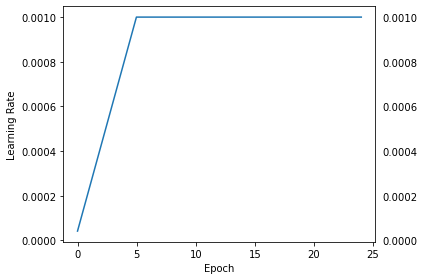

In [30]:
show_lr_history(trainer, EPOCHS)

In [31]:
print(f"Max LR = {max(trainer.lr_history)}")
print(f"Min LR = {min(trainer.lr_history)}")

Max LR = 0.001
Min LR = 4.196319018404908e-05


# Test Misclassified images

In [33]:
misclassified_images, predictions, labels = tester.get_misclassified_images()

# Display the Misclassified images

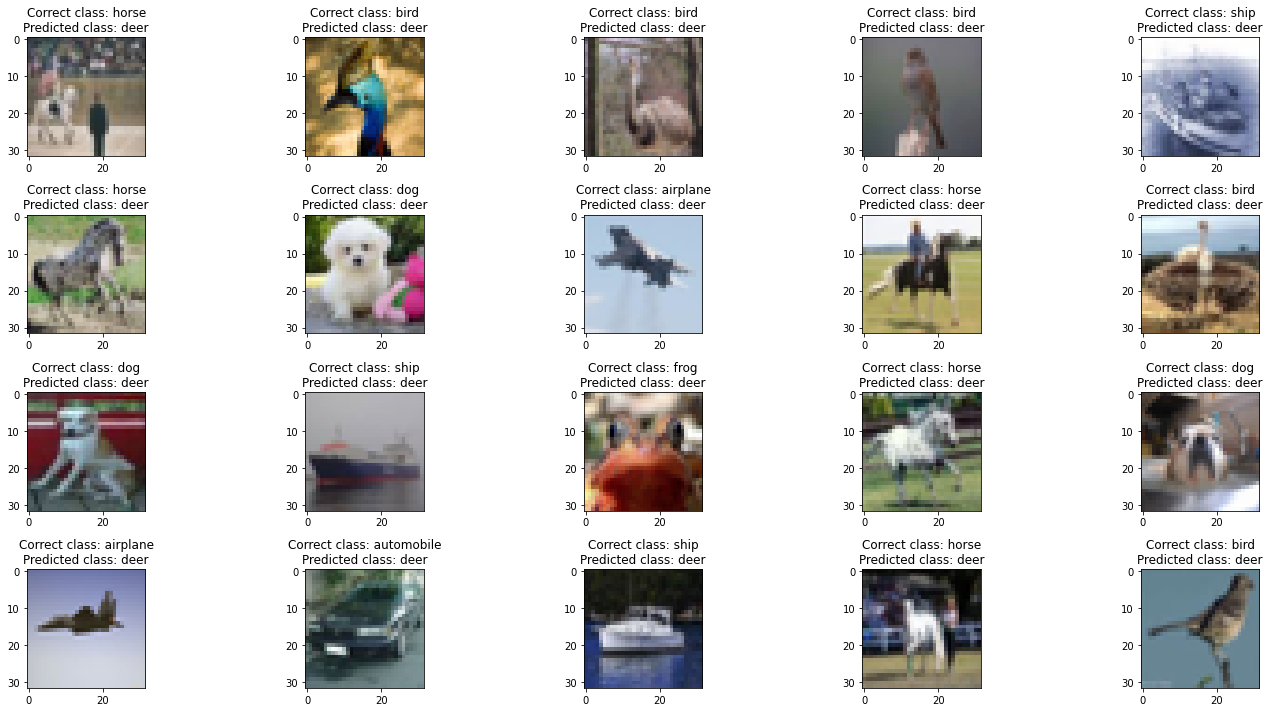

In [34]:
show_misclassified_images(misclassified_images[:20], predictions[:20], labels[:20], cifar10.classes)

# Loss and Accuracy Graphs for Training and Testing

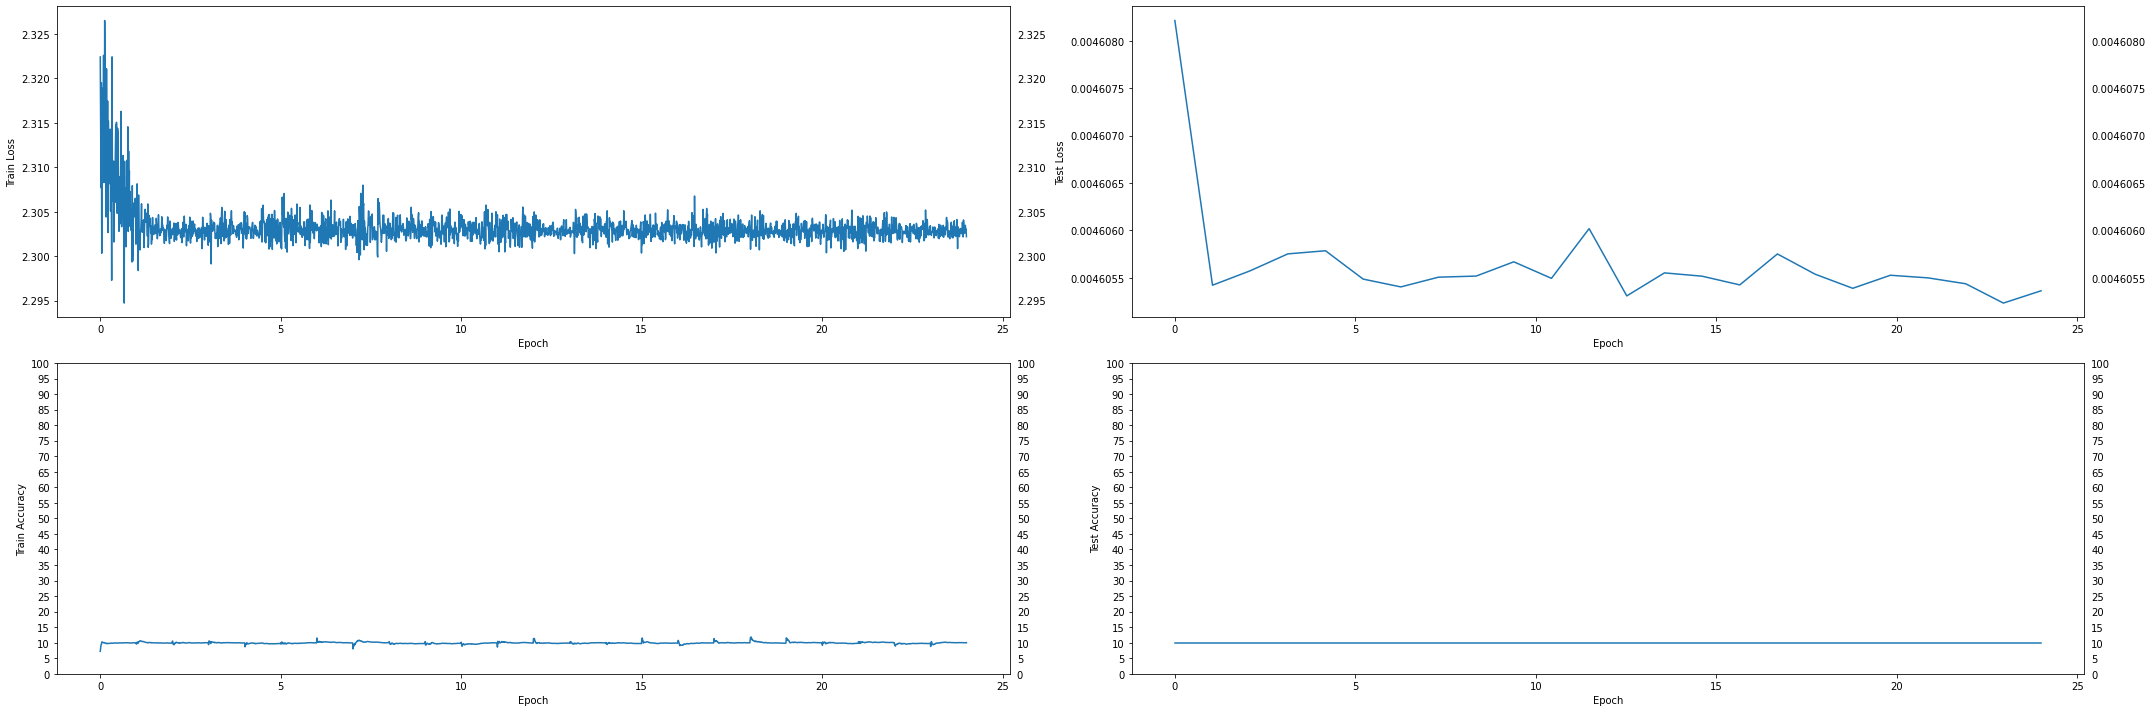

In [35]:
show_losses_and_accuracies(trainer, tester, EPOCHS)

In [39]:
import torchvision.datasets as datasets
testset = datasets.CIFAR10(root='./data', train=False,download=True)    
testloader = DataLoader(testset, batch_size=128,shuffle=False, num_workers=2)

Files already downloaded and verified


In [45]:
# Evaluate on test set
transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

testset = datasets.CIFAR10(root='./data', train=False,
                           download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128,
                         shuffle=False, num_workers=2)

ultimusNet.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = ultimusNet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


Files already downloaded and verified
Accuracy of the network on the test images: 10 %
